# PGs generation, detection & recognition via learning delays

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

INFO       Cache size for target "cython": 2204 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\camil\.cython\brian_extensions" directory. [brian2]


On s'intéresse ici à la génération, la détection et l'apprentissage de patterns temporels grâce à l'apprentissage des délais de manière à ce qu'un pattern temporel d'intéret s'articule en groupe polychrone (PG). Un groupe polychrone est définit par un groupe de neurone qui déchargent de manière asycnhrone, à différents moments, mais qui, grâce à leurs délais, transmettent l'information à un neurone post synaptique de façon sychrone.

L'idée ici est dans un premier temps de réaliser un modèle génératif de pattern temporel et un modèle de détection de groupes polychrones en Brian. Pour celà, on utilise un réseau de neurone à spike de trois couches : 
- la première couche est constituée de neurones du SpikeGeneratorGroup A et sert à la génération.
- la deuxième couche est constituée de neurones appartenant au NeuronGroup B et sert à la génération. 
- la troisième couche est constituée de neurones appartenant au NueronGroup C et sert à la détection.

Les neurones de la couche A vont émettrent un spike à un moment donné de la simulation. Chaque neurone de cette couche projette sur au moins trois neurones de la couche B, selon un certain poid et un certain delais. Si un neurone de la couche A spike, alors les neurones de la couche B sur lesquels il projette vont emettrent un spike (en fonction de leur poid et de leur délai). Tous les neurones de la couche B qui déchargent en réponse au spike du neurone de la couche A consitituent un groupe polychrone. 
Avec cette organisation, on génère un rasterplot artificiel (actvité des neurones de la couche B) dans lequel on voudrait détecter des groupes polychrones. Les spikes appartenant à un même groupe sont déterminés en fonction du neurone de la couche A qui a engendré leur décharge. L'activité de la couche B correspond donc à notre entrée et l'activité des neurones de la couche A correspond à notre ground truth, ce que l'on voudrait détecter. Un spike d'un neurone dans la couche A correspond à l'occurence d'un groupe polychrone. 
Puisque l'on connait les connections a->b, les poids et les délais, il est facile d'organiser un groupe de neurone en groupe polychrones en réalisant une troisièmpe couche, équivalente à la couche a. On construit des connections b->c de la même manière que a->b, avec les mêmes poids. On ajuste les délais de sorte à ce que les spikes d'un groupe de neurones polychrone arrivent de façon synchrone sur un neurone de la couche c et induisent leur décharge. Lorsqu'un neurone c spike ça veut dire que les neurones projettant sur lui spike avec une certaine séquence temporelle. On detecte donc une séquence temporelle d'intéret à un moment dans le temps. En récupérant les délais on peut connaitre cette séquence temporelle. 

### variable definition

In [2]:
Ni = 3 #nb de PGs différents
Nj = 10 #nb d'adresses en entrée 
n_pattern = 60 # nb d'occurrence des PGs 
duration = 30*second

PGs_pattern = {}
PGs_id_tps = {}
detection = {}
state_b = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [3]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []
nn_j = []
W = []

for k in range(Ni) : 
    n_j = np.random.randint(3, Nj, size = 1) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    W.append(list(np.random.rand(int(n_j))))
    W[k] /= sum(W[k])
    nn_j.append(n_j)

n_syn = sum(n_syn) 

# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 ? 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 -> 144 

### NN simulation for PGs generation and detection

In [4]:
def generator_terminator(nn_j, i_syn, i_indices, i_temps):
    
    start_scope()

    e_in = []
    e_true = []       
        
# --- generation de e_in ----------------------------------------------------------------------------------------------------------
    for i in range(n_pattern) :    
        
        a = SpikeGeneratorGroup(Ni, [i_indices[i]], [i_temps[i]/ms*msecond])
        a_spike= SpikeMonitor(a)
    
        b = NeuronGroup(Nj, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.01999*volt',
                        reset= 'v = 0*volt',
                       method = 'exact')
        b.v = 0*volt
        b.tau = 0.001*second
        b_spike = SpikeMonitor(b)
        b_state = StateMonitor(b, 'v', record = True)

        s = Synapses(a,b, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
        for k in range(Ni):
            s.connect(i = k , j = i_syn[k])
            s.w[k,:] = W[k]*20 
            
        s.delay[:,:] = delay
    
    # --- generation de e_true/detectorrr_terminator ----------------------------------------------------------------------------------
       
        c =  NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.005*volt',
                        reset= 'v = 0*volt',
                        method = 'exact')
    
        c.v = 0*volt
        c.tau = 0.001*second
        c_spike = SpikeMonitor(c)
    
        syn = Synapses(b,c, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
        for k in range(Ni):
            syn.connect(i = i_syn[k], j = k)         
            syn.w[:,k] = W[k]
            syn.delay[:,k] = max(s.delay[k,:])-s.delay[k,:]
    
    
        net_g = Network(collect())
        net_g.add(a, a_spike, b, b_spike, c, c_spike, s, syn)
        net_g.run(duration)
    

    # --- stock dans des variables ----------------------------------------------------------------------------------------------------
        
        PGs_id_tps[i] = (a_spike.t, a_spike.i) # generator
        PGs_pattern[i] = (b_spike.t, b_spike.i) # generator
        detection[i] = (c_spike.t, c_spike.i) # generator, detector (-max(syn.delay[:,[c_spike.i]]) pour que ce soit le premier spike que l'on detecte, peut etre pas essentiel
        
        
        e_true.append(tuple((np.round(detection[i][0]*1000/second), detection[i][1])))
        
        for k in range(len(PGs_pattern[i][0])):
            e_in.append(tuple((round(PGs_pattern[i][0][k]*1000/second), PGs_pattern[i][1][k])))
        
    e_in.sort(key=lambda y: y[0]) #pour trier de tmin à tmax
    e_true.sort(key=lambda y: y[0]) #pour trier de tmin à tmax
        
    return s, syn, PGs_id_tps, PGs_pattern, detection, e_in, e_true



# --- visualisation -----------------------------------------------------------------------------------------------

    # --- de l'activité ---------------------------------------------------------------------------------------------------------

def plot_generator(lolo) : 
    plt.figure(figsize=(10,5))
    for i in range(n_pattern) :
        plt.scatter(lolo[i][0], lolo[i][1], color = color_dict[i_indices[i]], marker = "|")
        
    # --- des connections ----------------------------------------------------------------------------------------------------
        
def visualise_connectivity(s): # ajouter les delays
    Ns= len(s.source)
    Nt = len(s.target)
    figure(figsize=(15,8))
    
    subplot(141)
    plot(zeros(Ns), arange(Ns), 'ok', ms=7)
    plot(ones(Nt), arange(Nt), 'ok', ms=7)
    for i, j in zip(s.i, s.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    
    subplot(142)
    plot(s.i, s.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(143) 
    scatter(s.i, s.j, s.w*30 )
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(144) 
    scatter(s.i, s.j, s.delay*300)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [5]:
start_scope()
s, syn, PGs_id_tps, PGs_pattern, detection, e_in, e_true = generator_terminator(nn_j, i_syn, i_indices, i_temps)

WARNING    C:\Users\camil\AppData\Local\Temp/ipykernel_51288/853326887.py:70: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  e_true.sort(key=lambda y: y[0]) #pour trier de tmin à tmax
 [py.warnings]


Text(0.5, 1.0, 'occurence of PGs')

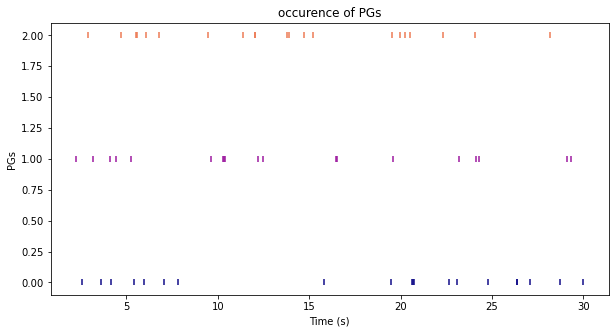

In [6]:
occurence_PGs = plot_generator(PGs_id_tps)
xlabel('Time (s)')
ylabel('PGs')
title('occurence of PGs')

Text(0.5, 1.0, 'e_in')

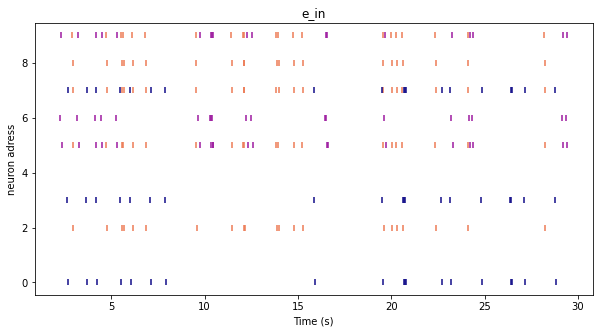

In [7]:
raster_plot = plot_generator(PGs_pattern)
xlabel('Time (s)')
ylabel('neuron adress')
title('e_in')

In [8]:
syn.delay[:,0], syn.delay[:,2]

(array([59.0089391 , 33.13229993,  0.        ]) * msecond,
 array([55.21769161, 23.62939271, 40.07142803,  0.        ,  4.31389091,
        13.083392  ,  8.39048592]) * msecond)

Text(0.5, 1.0, 'detection of PGs')

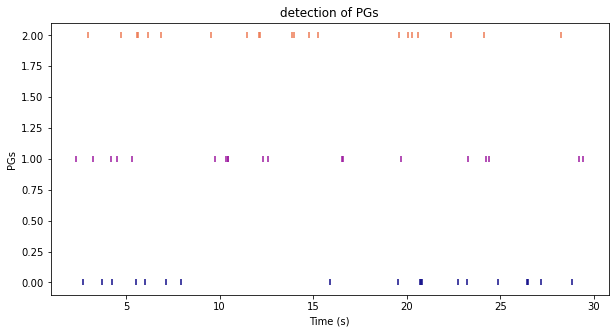

In [ ]:
detection_PGs = plot_generator(detection)
xlabel('Time (s)')
ylabel('PGs')
title('detection of PGs')

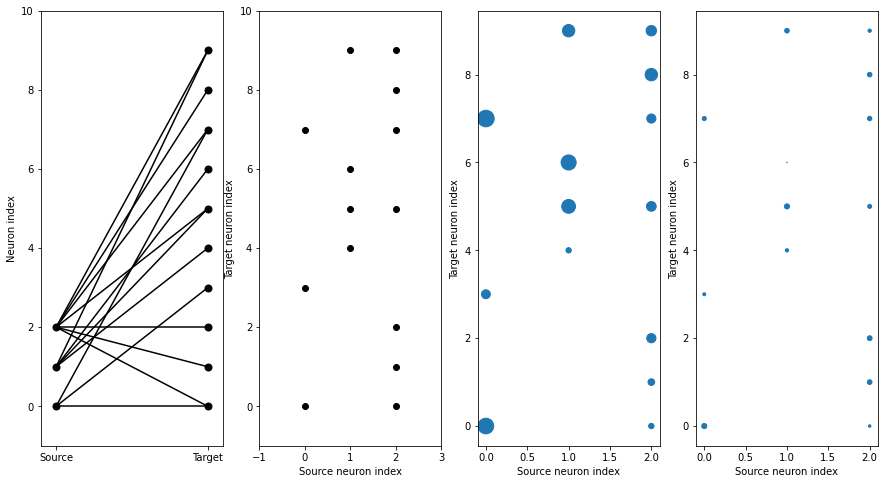

In [10]:
visualise_connectivity(s)

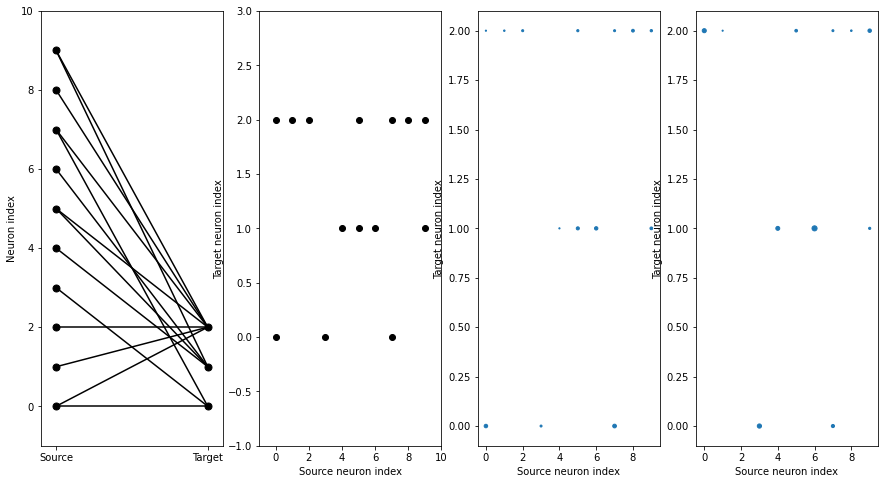

In [11]:
visualise_connectivity(syn)

ici, ce sont les connections b->c qui déterminent les neurones impliqués dans un PG, les poids sont donc obsolètes pour la détection des PGs. Ils décervent même un peu, par exemple pour la détection du PG 2, la somme des poids est faible et donc la synchronisation des décharges des neurones le composant ne permet pas de dépasser le seuil de 0.02, j'ai du l'abaisser à 0.01. 
Il faudrait plutot faire une couche de détections où tous les b connectent tous les c et où les poids sont importants pour les neurones où a->c existe et faibles pour les connections où a->c n'existe pas. (ici b->c n'existe que si a->c existe, les poids ne servent donc à rien)

# supervised learning of weight and delay for recognition of PGs

l'idée serait d'apprendre dans un premier temps les poids, pour selectionner les neurones impliqués dans une séquence temporelle. Pour cela, il faut dans un premier temps, créer mon e_out (couche de Ni neurones, qui servent à detecter les groupes polychrones, W aléatoires, d = 1ms), ensuite, réaliser mon detecteur de synchronie (x = all_spike_time_x ; y_true = all_spike_time_y ; y = e_out).
C'est dans le detecteur de synchronie que va se réaliser l'apprentissage : comparaison de x et y_true, plus ils sont synchrones, plus on détermine un w grand, ce w sera appliqué a e_out. si x arrive après y_true : poids négatifs, si x arrive avant : poids positifs. 
Avant apprentissage, e_out va spiker n'importe comment, après l'apprentissage, il va spiker que pour la detection de PG. 
Commencer par e_out = 1 pour detection de 1 PG au milieu des autres qui représenteront le bruit. Determiner un seuil ni trop grand, ni trop petit pour que ça soit ok (peut etre se référer au seuil de detection si les poids sont du meme ordre de grandeur que syn.w)
Avec n run = n epoch on devrait apprendre. 
Tout ça se fait en numpy.

Ensuite, on apprendrait les délais necessaires pour synchroniser les neurones de ce groupe. En récupérant les poids on pourrait connaitre les neurones impliqués dans un groupe et en récupérant les délais necessaire à la synchronisation, on pourrait connaitre la séquence temporelle qu'ils constituent.


## learning of weight 

In [12]:
N_epoch = 25


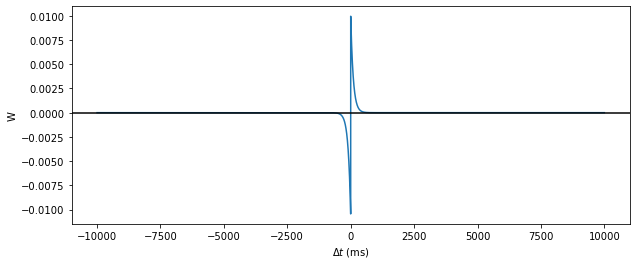

In [219]:
tau_pre = tau_post = 100*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-10000, 10000, 20000)*msecond

w_stdp = where(delta_t>=0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
    
plt.figure(figsize=(10,4))
plot(delta_t/ms, w_stdp)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');
    

In [226]:
def synchro_detector_terminator(e_true, e_in):
    
    e_in.sort(key=lambda y: y[1]) #pour trier de N
    e_true.sort(key=lambda y: y[1]) #pour trier de tmin à tmax
    
    delta_T = []
    comparaison = []
    delta_T_comp = []
    w_per_spike_pair = [] #shape(Nj,Ni)
    w_per_spike_pair_with_comp = []
    w_per_synapse_mean = {}
    
    
    for i in range(len(e_in)):
        for k in range(len(e_true)): 
            if e_true[k][0].size > 0 : 
                comparaison.append(tuple((e_in[i][1], e_true[k][1]))) #Nj,Ni
                delta_T.append(e_true[k][0]*ms - e_in[i][0]*ms)
    
    for i in range(len(delta_T)):
        delta_T_comp.append(tuple((delta_T[i], comparaison[i])))
    
    for i in range(len(delta_T)):       
        w_per_spike_pair.append((where(delta_T[i]>=0, A_pre*exp(-delta_T[i]/tau_pre), A_post*exp(delta_T[i]/tau_post))))
        w_per_spike_pair_with_comp.append(tuple((w_per_spike_pair[i], comparaison[i])))
    
    w_per_spike_pair_0 = {}
    w_per_synapse = {}
    w_per_synapse_list = []
    
    for k in range(Nj):
        for c in range(Ni):
            w_per_spike_pair_0[k,c] = list()
            
    for i in range(len(w_per_spike_pair_with_comp)):
        for k in range(Nj): 
            for c in range (Ni): 
                if w_per_spike_pair_with_comp[i][1]==(k,c):
                    w_per_spike_pair_0[k,c].append(w_per_spike_pair_with_comp[i][0])
                w_per_synapse[k,c] = mean(w_per_spike_pair_0[k,c])
    
    for k in range(Nj):
        for c in range(Ni):
                w_per_synapse_list.append(w_per_synapse[k,c])
    
    w_per_synapse_list = np.nan_to_num(w_per_synapse_list, -.1*10e-50)

    
    plt.figure(figsize=(10,4))
    plt.scatter(delta_T/ms, w_per_spike_pair)
    xlabel(r'$\Delta t$ (ms)')
    ylabel('W')
    axhline(0, ls='-', c='k');
    
    return delta_T, w_per_synapse_list, w_per_spike_pair_0, w_per_spike_pair_with_comp, delta_T_comp,w_per_synapse



WARNING    C:\Users\camil\AppData\Local\Temp/ipykernel_51288/4267430480.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  e_true.sort(key=lambda y: y[1]) #pour trier de tmin à tmax
 [py.warnings]
WARNING    C:\Users\camil\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


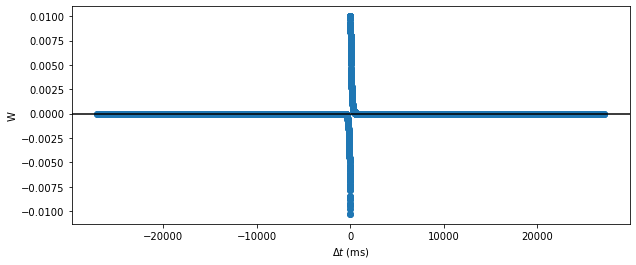

In [227]:
delta_T,w_per_synapse_list, w_per_spike_pair_0, w_per_spike_pair_with_comp, delta_T_comp,w_per_synapse= synchro_detector_terminator(e_true,e_in)

In [249]:
def neural_network(e_in, w_per_synapse_list):
    start_scope()
    
    PGs_learning = {}
    ind_in = []
    temps_in = []
    thresh = 0.04*volt # /!\

    # --- generation du NN -------------------------------------------------------------------------------------------
    
    for i in range(len(e_in)): 
        temps_in.append((e_in[i][0])*ms)
        ind_in.append(e_in[i][1])
        
    d = SpikeGeneratorGroup(Nj, ind_in, temps_in)
    d_spike = SpikeMonitor(d)

    e = NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                    tau : second''',
                    threshold= 'v > 0.04*volt',
                    reset= 'v = 0*volt',
                    method = 'exact')
    e.v = 0*volt
    e.tau = 0.001*second
    e_spike = SpikeMonitor(e)
 
    naps = Synapses(d, e, on_pre = '''v_post += 0.01*w*volt''', model = '''w:1''')

    naps.connect(p=1)
    naps.w = w_per_synapse_list*10e3
    
    for i in range(Ni):
        if max(naps.w[:,i])*0.01*volt < thresh : 
            for j in range(Nj):
                if naps.w[j,i]==max(naps.w[:,i]):
                    naps.w[j,i] = max(naps.w[:,i])*2  #max(w) trop faible pour un PG, donc je fais ça pour compenser mais pas une bonne idée.. 
                           
    run(duration)
    
    PGs_learning = (e_spike.t, e_spike.i)
    e_out = []
    
    for i in range(len(PGs_learning[0])):
        e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
    return e_out, naps, e_spike, d_spike, PGs_learning


In [250]:
start_scope()
e_out,naps,e_spike, d_spike , PGs_learning= neural_network(e_in, w_per_synapse_list)

Text(0.5, 1.0, 'e_in')

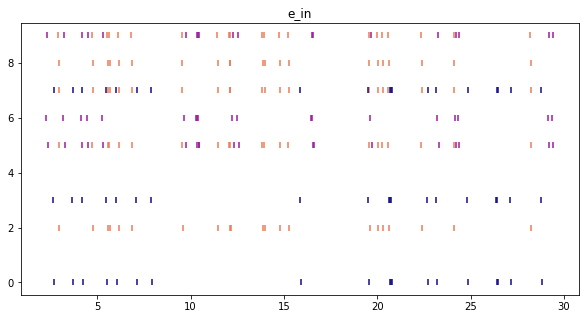

In [48]:
plot_generator(PGs_pattern)
title('e_in')

Text(0.5, 1.0, 'e_out')

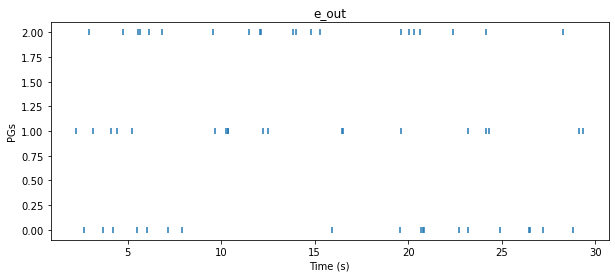

In [251]:
plt.figure(figsize = (10,4))
plt.scatter(e_spike.t, e_spike.i, marker = '|')
xlabel('Time (s)')
ylabel('PGs')
title('e_out')

#c'est ok pour PGs 0 et 2, STDP apprend un poid élever pour la synaspe du dernier Nj a spiker et un faible poid pour les autres
# par contre pour PGs1, la STDP sort un poid max de 2, trop faible. Comment faire pour potentialiser le poid maximum de naps.w[:,2] ? 
# j'ai fais un truc mais je pense pas que ce soit une bonne idée, too much spike

Text(0.5, 1.0, 'e_true')

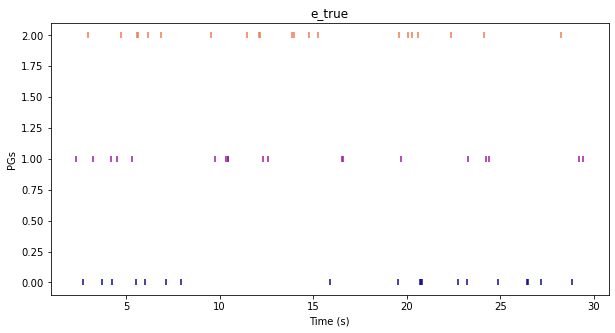

In [49]:
plot_generator(detection)
xlabel('Time (s)')
ylabel('PGs')
title('e_true')

Text(0.5, 1.0, 'delay PGs')

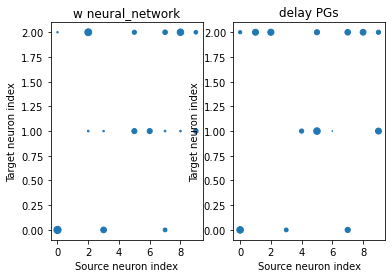

In [255]:
plt.figursubplot(121)

scatter(naps.i, naps.j, w_per_synapse_list*10e4)
xlabel('Source neuron index')
ylabel('Target neuron index')
title('w neural_network')

subplot(122)
scatter(s.j, s.i, s.delay*500 )
xlabel('Source neuron index')
ylabel('Target neuron index')
title('delay PGs')


In [254]:
# la STDP donne un poid élevé aux derniers spikes composant un PGs

In [ ]:
 def learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False, **kwargs): 
    
        sample = {'e_in': e_in, 'e_true': e_true}
    
        loader = DataLoader(sample, batch_size=batch_size, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
        train_ein_eout_ = neural_network(e_in) #pb : dans logistic_regression on returnait un NN, donc quand on faisait ça, train_ein_eout était un NN, ici c'est un tuple, donc on ne peut pas l'entrainer : what can i do ? 
        train_ein_eout_.to(device)
        train_ein_eout_.train()
    
        optimizer = torch.optim.Adam(train_ein_eout_.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
        for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
       
            train_ein_eout_.train()
            losses = [] 
        
            for e_in_, labels_ in loader: 
                e_in_, labels_ = e_in_.to(device), labels_.to(device)
                outputs = neural_network(e_in_)  
                loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
        
                losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    train_ein_eout.eval()
    e_in_0, labels = torch.Tensor(e_in[:, None]), torch.Tensor(e_true[:, None]) #utile ? 
    e_out = neural_network(e_in_0) #utile ? 
    loss = criterion(e_out, labels).item()
    
    return train_ein_eout, loss
    # --- visualisation ----------------------------------------------------------------------------------------------------------

def plotor(lolo):
    plt.figure(figsize=(10,4))
    plt.scatter(lolo.t, lolo.i, marker = "|")
    
def plotorr(lolo):
    temps_true = []
    ind_true = []
    for i in range(len(e_true)): 
        temps_true.append(e_true[i][0]*ms)
        ind_true.append(e_true[i][1])
        plt.scatter(temps_true[i],ind_true[i])

def plot_weight(lolo):
    plt.figure(figsize=(10,4))
    plot(lolo)
    xlabel('Time (s)')
    ylabel('weight')
    title ('evolution of weight of each synapse')
        
# --- supervised learning ----------------------------------------------------------------------------------------------------------

import torch
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 25 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 1000
n_classes = Nj

def learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False, **kwargs): 
    
    sample = {'e_in': e_in, 'e_true': e_true}
    
    
    loader = DataLoader(sample, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_ein_eout_ = neural_network(e_in)
    train_ein_eout_.train()
    
    optimizer = torch.optim.Adam(train_ein_eout_.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        train_ein_eout_.train()
        losses = [] 
        for e_in_, labels_ in loader: 
            e_in_, labels_ = e_in_.to(device), labels_.to(device)
            outputs = neural_network(e_in_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    train_ein_eout.eval()
    e_in_0, labels = torch.Tensor(e_in[:, None]), torch.Tensor(e_true[:, None]) #utile ? 
    e_out = neural_network(e_in_0) #utile ? 
    loss = criterion(e_out, labels).item()
    return train_ein_eout, loss


In [ ]:
train_ein_eout, loss  = learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False)

In [ ]:
plotor(d_spike)
xlabel('Time (s)')
ylabel('neurons')
title('e_in')

In [ ]:
plt.scatter(e_spike.t, e_spike.i)
xlabel('Time (s)')
ylabel('PGs')
title('e_out')

In [ ]:
plot_generator(detection)
xlabel('Time (s)')
ylabel('PGs')
title('e_true')

In [ ]:
visualise_connectivity(naps)

In [ ]:
### la stdp ne semble pas marcher 

In [ ]:
plot_weight(mon.w.T)

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj), naps.w)

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj),mon.w.T[0])

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj),mon.w.T[100000])

In [ ]:
plot?


In [ ]:
range?

### STDP

In [ ]:
len(w_per_synapse_list)

In [ ]:
w_per_synapse[0,0]

In [ ]:
for i in range(len(w_comp)):
    if w_comp[i][1]==(0,4):
        print(w_comp[i])

In [ ]:
a

In [ ]:
len(e_true)

In [ ]:
w, w_comp = synchro_detector_terminator(e_true, e_in)

In [ ]:
comp = []
delta_ttt = []
delta_tt = []

for i in range(len(e_true)):
    for k in range(len(e_in)):
        comp.append(tuple((e_true[i][1], e_in[k][1])))
        delta_tt.append(e_true[i][0] - e_in[k][0])

In [ ]:
for i in range(len(comp)):
    delta_ttt.append(tuple((delta_tt[i], comp[i])))

In [ ]:
Www = np.zeros((Ni,Nj))
for i in range(len(delta_ttt)):
    for k in range(Ni):
        for c in range(Nj) :
            if delta_ttt[i][1] == (k,c) :
                Www[k][c] == (delta_ttt[i][0])

In [ ]:
Www

In [ ]:
for i in range(len(e_true)): 
    if e_true[i][1]==2:
        print(e_true[i][0])

In [ ]:
for i in range(len(e_in)): 
    if e_in[i][1]==0:
        print(e_in[i][0])

# unsupervised recognition of PGs

## detection of temporal patterns 

In [ ]:
all_spike_time

In [ ]:
temps_tot

In [ ]:
# def de ma fenetre temporelle pour reconnaître les PGs
temps_tot = int(duration/msecond)
t_window = 200 #ms
nb_wind = int(temps_tot/t_window)
X = np.zeros((nb_wind, Nj, t_window))

In [ ]:
for k in range(nb_wind) :
    for t,i in (all_spike_time) : 
        if t<t_window : 
            X[1][i][t] = 1 #on peut faire [1,i,t]
            print('ok')
        if t_window*(k-1)<t<t_window*k : 
            X[k][i][t-t_window*(k-1)] = 1 
            print('okk')

In [ ]:
X[

In [ ]:
plot(X[58].T)

In [ ]:
all_spike_time

## cam's k-means